# Learning To Rank Currency Investments

## 8 Features and Targets Reengineering

### Prerrequisites

In [1]:
# Cloud/Local Env Handling
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  PATH = "/content/drive/MyDrive/"
  PATH_INSTALL_REQUIREMENTS = "/content/drive/MyDrive/Colab\ Notebooks/requirements.txt"  
  import sys
  sys.path.append(PATH + "Colab Notebooks")
except:  
  import os
  if os.name=="nt":
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "\\requirements.txt"  
  else: #Unix system
    PATH_INSTALL_REQUIREMENTS = os.getcwd() + "/requirements.txt"  
  PATH=""

In [ ]:
%pip install -r {PATH_INSTALL_REQUIREMENTS}

import pandas as pd
import yfinance as yf
import riskfolio.RiskFunctions as rf

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import gc

# Custom Handmade Modules (please copy folder to Colab Notebooks root)
from modules import performance_measures_helper as pms
import importlib # for continuous reloading

# For Ratios with Extreme Values
from scipy.stats.mstats import winsorize

# For Serializing
import pickle

### Imports and Checks

In [139]:
with open(PATH + "fx_data/FX_features_pd135_allPMs.pkl","rb") as handle:
    features_dict = pickle.load(handle)

features_dict.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80', 'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80', 'RACHEV1M99', 'RACHEV1M95', 'RACHEV1M90', 'RACHEV1M80', 'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80', 'RACHEV6M99', 'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M', 'SORTINO3M', 'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M'])

In [5]:
len(features_dict.keys())

46

In [6]:
# picking Omega 6M (long window-feature) for target analysis
Omega6M = features_dict["OMEGA6M"] 
Omega6M.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
Omega6M.dropna().head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,0.875331,0.828748,1.085825,0.995638,1.217466,0.912478,0.969428,0.853330,0.907952,0.979892
2004-05-26,0.888010,0.841193,1.112966,1.034997,1.242172,0.924394,0.984029,0.887935,0.931953,1.004830
2004-05-27,0.877124,0.846673,1.213879,1.047627,1.258536,0.906165,0.949479,0.910483,0.897468,0.976789
2004-05-28,0.870054,0.859750,1.185927,1.055534,1.282520,0.935422,0.937711,0.897720,0.890860,0.980092
2004-05-31,0.908392,0.870074,1.153634,1.053867,1.299857,0.950568,0.939966,0.948730,0.877162,1.007175


In [8]:
Omega6M.dropna().describe()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
count,4755.000000,4755.000000,4755.000000,4755.000000,4755.000000,4755.000000,4755.000000,4755.000000,4755.000000,4755.000000
mean,1.045138,1.057253,1.097583,1.021897,1.017148,1.007173,1.017661,1.048712,0.997967,1.047335
std,0.204210,0.227096,0.329735,0.190142,0.198854,0.217084,0.176641,0.197863,0.161719,0.255920
min,0.524034,0.600588,0.514626,0.551060,0.521906,0.476119,0.498678,0.554713,0.554199,0.583924
25%,0.886786,0.888915,0.905118,0.896663,0.874973,0.838704,0.883187,0.906160,0.886121,0.847404
50%,1.031972,1.033324,1.052038,0.994405,0.999233,0.981127,1.017356,1.051931,0.989953,1.019798
75%,1.171200,1.202960,1.227677,1.112419,1.157468,1.151862,1.128458,1.181925,1.106154,1.196789
max,1.769123,2.264360,8.529508,2.106832,1.681871,2.060500,1.624102,1.667711,1.561307,2.219353


<AxesSubplot:ylabel='Density'>

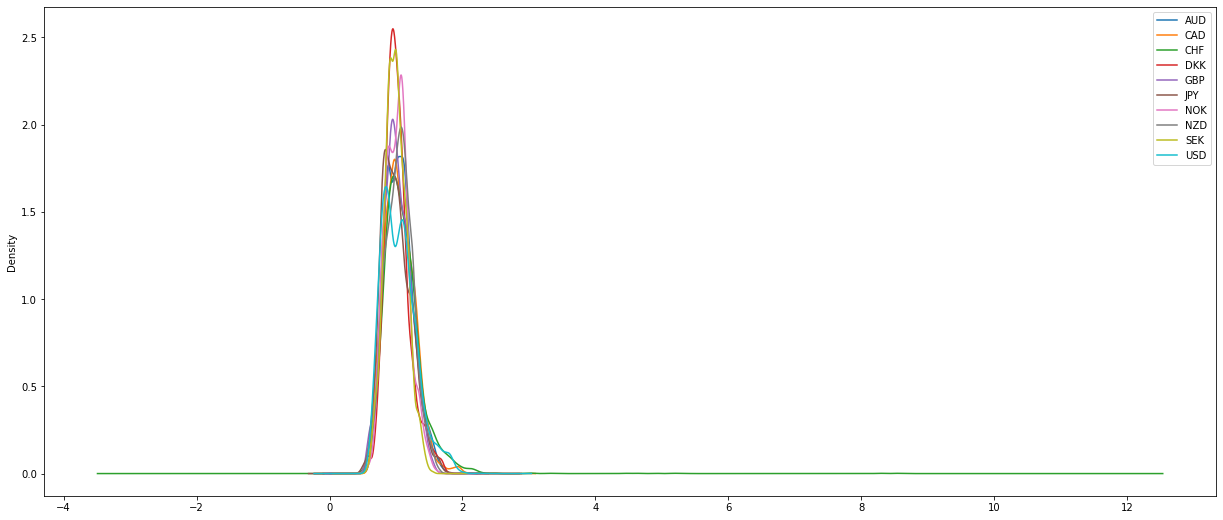

In [9]:
Omega6M.dropna().plot.density(figsize=(21,9))

In [18]:
fx_prices = pd.read_csv(
    PATH + "fx_data/inverse_FX_rates.csv",
    index_col="Date",
    parse_dates=["Date"]    
)

fx_prices.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,0.608532,0.641190,0.644122,0.134412,1.437401,0.007658,0.122489,0.537519,0.110926,0.83577
2003-12-02,0.605877,0.638162,0.642591,0.134382,1.432665,0.007608,0.122496,0.535045,0.111015,0.82720
2003-12-03,0.608236,0.634558,0.641890,0.134387,1.427144,0.007618,0.123183,0.533561,0.111458,0.82488
2003-12-04,0.609310,0.631752,0.642674,0.134401,1.424907,0.007648,0.123704,0.534759,0.111595,0.82775
2003-12-05,0.604522,0.629882,0.644995,0.134400,1.422475,0.007649,0.123724,0.530082,0.111818,0.82055


In [ ]:
%whos

In [95]:
fx_prices.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,0.608532,0.641190,0.644122,0.134412,1.437401,0.007658,0.122489,0.537519,0.110926,0.83577
2003-12-02,0.605877,0.638162,0.642591,0.134382,1.432665,0.007608,0.122496,0.535045,0.111015,0.82720
2003-12-03,0.608236,0.634558,0.641890,0.134387,1.427144,0.007618,0.123183,0.533561,0.111458,0.82488
2003-12-04,0.609310,0.631752,0.642674,0.134401,1.424907,0.007648,0.123704,0.534759,0.111595,0.82775
2003-12-05,0.604522,0.629882,0.644995,0.134400,1.422475,0.007649,0.123724,0.530082,0.111818,0.82055


In [96]:
Omega6M

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.996316,1.233726,1.378513,1.036287,0.754291,0.929020,0.855858,0.832008,0.790286,1.581658
2022-09-27,0.982682,1.215647,1.358799,1.033172,0.774841,0.939921,0.813501,0.816741,0.789716,1.601420
2022-09-28,0.928355,1.182193,1.345788,1.017155,0.742521,0.930688,0.781534,0.771504,0.784478,1.585821


In [98]:
Omega6M.dropna(inplace=True)

In [99]:
Omega6M

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,0.875331,0.828748,1.085825,0.995638,1.217466,0.912478,0.969428,0.853330,0.907952,0.979892
2004-05-26,0.888010,0.841193,1.112966,1.034997,1.242172,0.924394,0.984029,0.887935,0.931953,1.004830
2004-05-27,0.877124,0.846673,1.213879,1.047627,1.258536,0.906165,0.949479,0.910483,0.897468,0.976789
2004-05-28,0.870054,0.859750,1.185927,1.055534,1.282520,0.935422,0.937711,0.897720,0.890860,0.980092
2004-05-31,0.908392,0.870074,1.153634,1.053867,1.299857,0.950568,0.939966,0.948730,0.877162,1.007175
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.996316,1.233726,1.378513,1.036287,0.754291,0.929020,0.855858,0.832008,0.790286,1.581658
2022-09-27,0.982682,1.215647,1.358799,1.033172,0.774841,0.939921,0.813501,0.816741,0.789716,1.601420
2022-09-28,0.928355,1.182193,1.345788,1.017155,0.742521,0.930688,0.781534,0.771504,0.784478,1.585821


In [100]:
fx_prices.pct_change()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,-0.004362,-0.004722,-0.002378,-0.000229,-0.003295,-0.006543,0.000061,-0.004601,0.000799,-0.010254
2003-12-03,0.003893,-0.005648,-0.001091,0.000040,-0.003853,0.001371,0.005605,-0.002775,0.003990,-0.002805
2003-12-04,0.001767,-0.004422,0.001221,0.000107,-0.001567,0.003824,0.004231,0.002246,0.001228,0.003479
2003-12-05,-0.007859,-0.002960,0.003612,-0.000013,-0.001707,0.000229,0.000161,-0.008746,0.002002,-0.008698
...,...,...,...,...,...,...,...,...,...,...
2022-09-23,0.004390,-0.000287,-0.008854,0.000027,-0.000137,0.013386,-0.003753,0.002497,0.001642,-0.001101
2022-09-26,-0.001645,0.007587,0.008827,-0.000054,-0.026418,0.007180,-0.002558,-0.002674,-0.005027,0.015648
2022-09-27,-0.002395,-0.002964,-0.003184,0.000039,0.004355,-0.000014,-0.011717,-0.006859,0.004433,0.006880


In [102]:
fx_returns = fx_prices.pct_change().fillna(0)
fx_returns.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2003-12-02,-0.004362,-0.004722,-0.002378,-0.000229,-0.003295,-0.006543,0.000061,-0.004601,0.000799,-0.010254
2003-12-03,0.003893,-0.005648,-0.001091,0.000040,-0.003853,0.001371,0.005605,-0.002775,0.003990,-0.002805
2003-12-04,0.001767,-0.004422,0.001221,0.000107,-0.001567,0.003824,0.004231,0.002246,0.001228,0.003479
2003-12-05,-0.007859,-0.002960,0.003612,-0.000013,-0.001707,0.000229,0.000161,-0.008746,0.002002,-0.008698


In [103]:
Omega6M

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,0.875331,0.828748,1.085825,0.995638,1.217466,0.912478,0.969428,0.853330,0.907952,0.979892
2004-05-26,0.888010,0.841193,1.112966,1.034997,1.242172,0.924394,0.984029,0.887935,0.931953,1.004830
2004-05-27,0.877124,0.846673,1.213879,1.047627,1.258536,0.906165,0.949479,0.910483,0.897468,0.976789
2004-05-28,0.870054,0.859750,1.185927,1.055534,1.282520,0.935422,0.937711,0.897720,0.890860,0.980092
2004-05-31,0.908392,0.870074,1.153634,1.053867,1.299857,0.950568,0.939966,0.948730,0.877162,1.007175
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.996316,1.233726,1.378513,1.036287,0.754291,0.929020,0.855858,0.832008,0.790286,1.581658
2022-09-27,0.982682,1.215647,1.358799,1.033172,0.774841,0.939921,0.813501,0.816741,0.789716,1.601420
2022-09-28,0.928355,1.182193,1.345788,1.017155,0.742521,0.930688,0.781534,0.771504,0.784478,1.585821


In [104]:
fx_returns = fx_returns[Omega6M.index[0]:]
fx_returns.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,0.006140,-0.009400,-0.002923,-0.000094,0.002996,0.003697,0.000693,0.004696,-0.001906,-0.008423
2004-05-26,-0.000117,0.000362,0.000065,0.000108,0.000750,-0.001845,0.003328,0.007404,0.003927,-0.000823
2004-05-27,0.000702,-0.003424,0.008516,0.000148,-0.001348,-0.005724,-0.002238,0.004857,-0.000561,-0.013443
2004-05-28,-0.000351,0.000661,-0.001243,0.000175,0.002552,0.014516,0.001571,-0.002114,0.000363,0.004738
2004-05-31,0.004111,0.000903,0.000458,-0.000027,0.001052,0.005765,0.000670,0.008370,0.000209,0.001564


In [106]:
omega6m_rank = Omega6M.rank(axis=1)
omega6m_rank.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,3.0,1.0,9.0,8.0,10.0,5.0,6.0,2.0,4.0,7.0
2004-05-26,3.0,1.0,9.0,8.0,10.0,4.0,6.0,2.0,5.0,7.0
2004-05-27,2.0,1.0,9.0,8.0,10.0,4.0,6.0,5.0,3.0,7.0
2004-05-28,2.0,1.0,9.0,8.0,10.0,5.0,6.0,4.0,3.0,7.0
2004-05-31,3.0,1.0,9.0,8.0,10.0,6.0,4.0,5.0,2.0,7.0


In [108]:
mask_best_currency = (omega6m_rank==10).shift(1).fillna(False)

In [109]:
mask_best_currency

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,False,False,False,False,False,False,False,False,False,False
2004-05-26,False,False,False,False,True,False,False,False,False,False
2004-05-27,False,False,False,False,True,False,False,False,False,False
2004-05-28,False,False,False,False,True,False,False,False,False,False
2004-05-31,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,False,False,False,False,False,False,False,False,False,True
2022-09-27,False,False,False,False,False,False,False,False,False,True
2022-09-28,False,False,False,False,False,False,False,False,False,True


In [110]:
fx_returns.shape[0]

4754

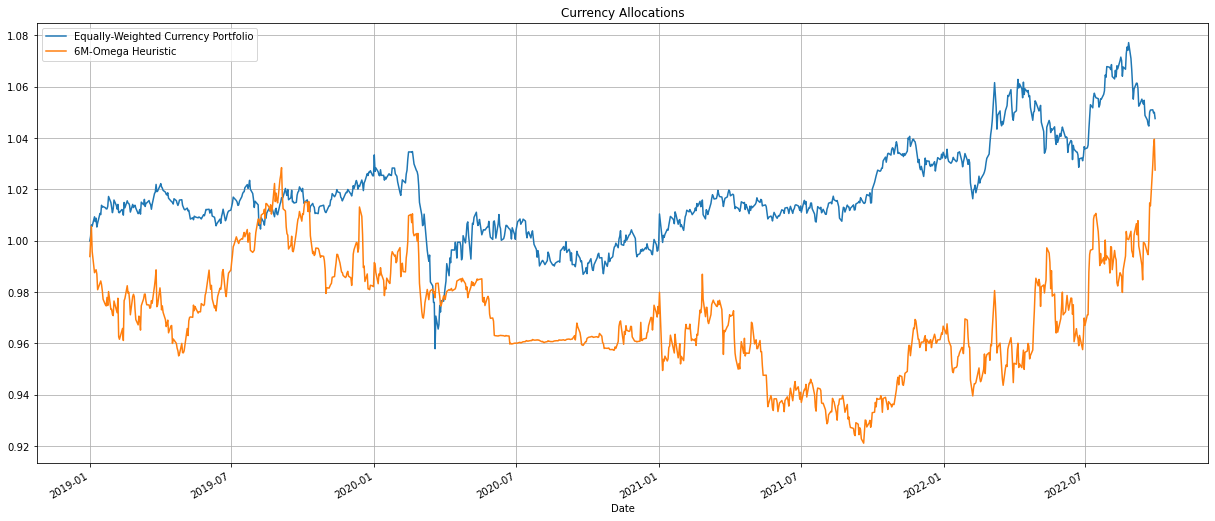

In [114]:
(1+fx_returns["2019":].mean(axis=1,skipna=True)).cumprod().rename("Equally-Weighted Currency Portfolio").plot(figsize=(21,9), title="Currency Allocations", legend=True)
(1+fx_returns["2019":][mask_best_currency].mean(axis=1,skipna=True)).cumprod().rename("6M-Omega Heuristic").plot(figsize=(21,9), title="Currency Allocations", legend=True)

plt.grid()

In [115]:
#Downsampling
omega6m_rank_monthly = omega6m_rank.resample("BM").apply(lambda x: x[-1])

In [ ]:
from modules import performance_measures_helper as pms

In [119]:
fx_returns_monthly = fx_returns.resample("BM").apply(pms.multi_period_return)

In [126]:
fx_returns_monthly

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-31,0.010513,-0.010890,0.004844,0.000309,0.006011,0.016397,0.004023,0.023395,0.002024,-0.016391
2004-06-30,-0.024577,0.023966,0.002954,0.000686,-0.005083,0.007012,-0.028320,0.005121,-0.007630,0.001232
2004-07-30,0.021178,0.015072,-0.010201,-0.000309,0.014869,-0.008596,0.001578,0.014364,-0.007174,0.013975
2004-08-31,-0.009962,0.000626,-0.002140,-0.000403,-0.023989,0.006697,0.008567,0.016597,0.010889,-0.013302
2004-09-30,0.009000,0.018873,-0.003553,-0.000511,-0.015167,-0.029008,0.002002,0.010234,0.009042,-0.020581
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,-0.013506,-0.013856,-0.011160,0.000269,-0.010824,-0.001954,-0.025660,-0.015256,-0.011541,-0.025000
2022-06-30,-0.013995,0.012981,0.035648,-0.000008,-0.010892,-0.035163,-0.019030,-0.021102,-0.017958,0.031297
2022-07-29,0.042607,0.031074,0.024632,-0.000442,0.028667,0.041643,0.041974,0.036576,0.027890,0.024946


In [127]:
omega6m_rank_monthly

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-31,3.0,1.0,9.0,8.0,10.0,6.0,4.0,5.0,2.0,7.0
2004-06-30,1.0,4.0,10.0,9.0,8.0,5.0,6.0,3.0,2.0,7.0
2004-07-30,1.0,7.0,6.0,10.0,8.0,4.0,9.0,2.0,3.0,5.0
2004-08-31,1.0,6.0,9.0,10.0,3.0,7.0,8.0,2.0,4.0,5.0
2004-09-30,1.0,9.0,7.0,8.0,3.0,2.0,5.0,6.0,10.0,4.0
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,9.0,10.0,5.0,2.0,4.0,1.0,7.0,6.0,3.0,8.0
2022-06-30,7.0,9.0,8.0,6.0,3.0,1.0,4.0,5.0,2.0,10.0
2022-07-29,7.0,9.0,8.0,2.0,3.0,1.0,5.0,6.0,4.0,10.0


In [129]:
mask = (omega6m_rank_monthly==10).shift(1)
oracle_mask = (omega6m_rank_monthly==10) # Non-Shifted Implies Oracle

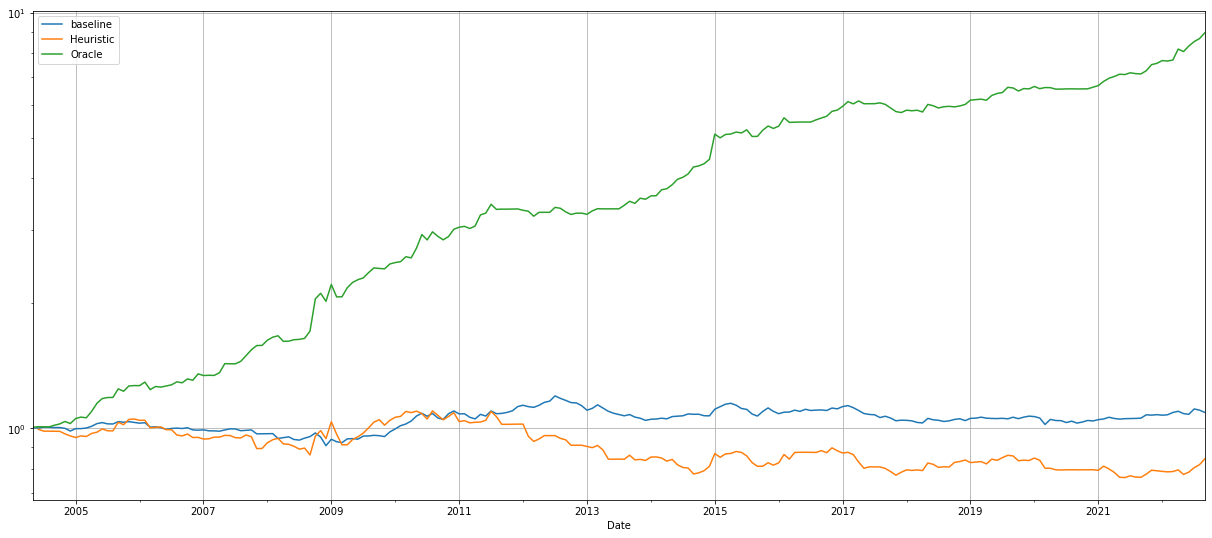

In [137]:
(1+fx_returns_monthly[mask.index[0]:].mean(axis=1, skipna=True)).cumprod().rename("baseline").plot(figsize=(21,9), legend=True)
(1+fx_returns_monthly[mask].mean(axis=1, skipna=True)).rename("Heuristic").cumprod().plot(legend=True)
(1+fx_returns_monthly[oracle_mask].mean(axis=1, skipna=True)).rename("Oracle").cumprod().plot(legend=True)

plt.semilogy()
plt.grid()

In [140]:
features_dict.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80', 'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80', 'RACHEV1M99', 'RACHEV1M95', 'RACHEV1M90', 'RACHEV1M80', 'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80', 'RACHEV6M99', 'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M', 'SORTINO3M', 'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M'])

In [142]:
features_monthly = {}
from tqdm import tqdm

for features in tqdm(features_dict):
    features_monthly[features] = features_dict[features].resample("BM").apply(
        lambda x: x[-1]
    )

100%|██████████| 46/46 [00:03<00:00, 11.84it/s]


In [143]:
features_monthly.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80', 'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80', 'RACHEV1M99', 'RACHEV1M95', 'RACHEV1M90', 'RACHEV1M80', 'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80', 'RACHEV6M99', 'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M', 'SORTINO3M', 'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M'])

In [145]:
features_monthly["MOM1W"]

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-31,0.000597,-0.003491,-0.003977,-0.000631,-0.003127,-0.011616,0.001669,0.000104,0.002470,-0.010884
2004-01-30,-0.001774,0.000909,-0.002169,-0.000255,0.008488,0.020647,-0.014205,0.009813,-0.009057,0.009223
2004-02-27,0.007807,0.004501,0.003111,-0.000228,0.007488,0.001172,0.003367,0.009974,-0.005346,0.003838
2004-03-31,0.013928,0.007755,-0.005072,0.000094,-0.004492,0.006469,-0.001685,0.010859,-0.000269,-0.014130
2004-04-30,-0.029373,-0.018995,0.003805,-0.000175,-0.007127,-0.022079,0.005829,-0.017627,-0.001103,-0.011092
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.006412,0.001907,-0.000378,-0.000102,-0.002266,-0.007998,0.013126,0.008547,-0.000171,-0.008492
2022-06-30,0.007442,0.017439,0.019073,-0.000247,0.001161,0.007030,0.014871,0.003778,-0.003807,0.011251
2022-07-29,0.013706,0.008496,0.015184,0.000313,0.017559,0.023019,0.025623,0.011237,0.001940,0.002821


In [146]:
pd.__version__

'1.4.2'

In [147]:
# Dumping Monthly DownSampled Features
with open(PATH + "fx_data/FX_features_all_monthly_pandas142.pkl","wb") as f:
    pickle.dump(features_monthly, f, protocol=pickle.HIGHEST_PROTOCOL)

In [148]:
Mom1M = features_dict["MOM1M"]
Mom1M_monthly = features_monthly["MOM1M"]

In [149]:
Mom1M.head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
Mom1M.dropna().head()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-30,-0.018984,-0.039537,-0.004042,-0.000618,-0.013751,-0.027120,-0.030289,-0.026835,-0.007683,-0.046532
2003-12-31,-0.014862,-0.040416,-0.001796,-0.000604,-0.007959,-0.027523,-0.026706,-0.027322,-0.006858,-0.039797
2004-01-01,-0.016745,-0.032240,-0.001346,-0.000671,-0.005253,-0.027776,-0.032258,-0.023040,-0.009429,-0.036478
2004-01-02,-0.009834,-0.024948,-0.001604,-0.000672,0.001856,-0.029034,-0.037070,-0.020532,-0.008465,-0.039819
2004-01-05,0.001210,-0.022655,-0.008061,-0.001034,0.001853,-0.030193,-0.042641,-0.001852,-0.015153,-0.039413


In [151]:
mom1m_rank = Mom1M.rank(axis=1)

In [152]:
mom1m_rank

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,5.0,7.0,9.0,8.0,2.0,6.0,1.0,3.0,4.0,10.0
2022-09-27,5.0,6.0,9.0,8.0,2.0,7.0,1.0,3.0,4.0,10.0
2022-09-28,4.0,6.0,9.0,8.0,3.0,7.0,1.0,2.0,5.0,10.0


In [153]:
mom1m_rank.dropna()

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-30,6.0,2.0,9.0,10.0,7.0,4.0,3.0,5.0,8.0,1.0
2003-12-31,6.0,1.0,9.0,10.0,7.0,3.0,5.0,4.0,8.0,2.0
2004-01-01,6.0,3.0,9.0,10.0,8.0,4.0,2.0,5.0,7.0,1.0
2004-01-02,6.0,4.0,8.0,9.0,10.0,3.0,2.0,5.0,7.0,1.0
2004-01-05,9.0,4.0,6.0,8.0,10.0,3.0,1.0,7.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,5.0,7.0,9.0,8.0,2.0,6.0,1.0,3.0,4.0,10.0
2022-09-27,5.0,6.0,9.0,8.0,2.0,7.0,1.0,3.0,4.0,10.0
2022-09-28,4.0,6.0,9.0,8.0,3.0,7.0,1.0,2.0,5.0,10.0


<AxesSubplot:xlabel='Date'>

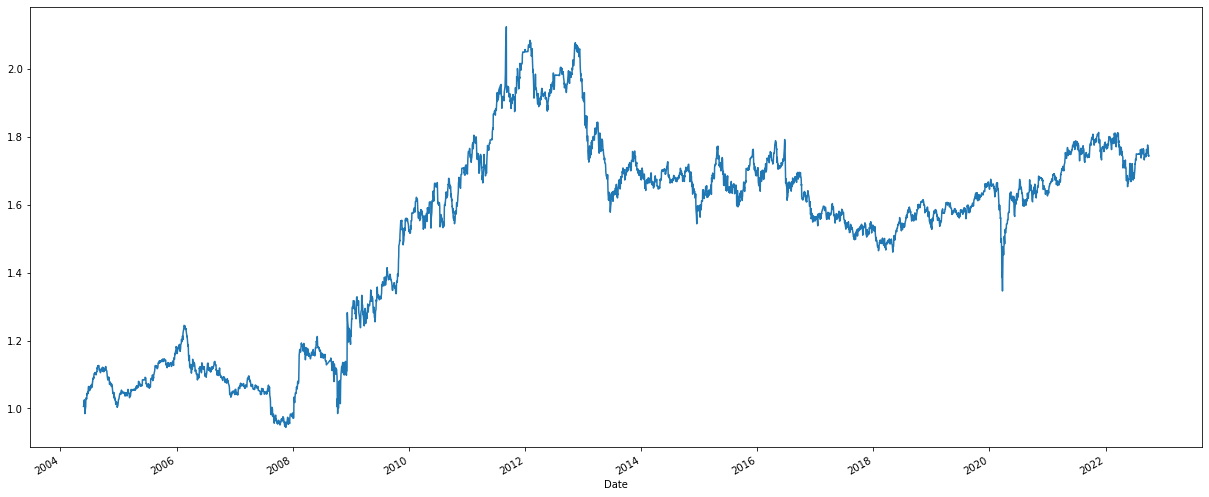

In [161]:
# However Picking The Worst Performers...
(1+fx_returns[(mom1m_rank==1).shift(1)].mean(
    axis=1,skipna=True
)).cumprod().plot(figsize=(21,9))

In [162]:
%whos DataFrame

Variable               Type         Data/Info
---------------------------------------------
Mom1M                  DataFrame                     AUD     <...>n[4881 rows x 10 columns]
Mom1M_monthly          DataFrame                     AUD     <...>\n[226 rows x 10 columns]
Omega6M                DataFrame                     AUD     <...>n[4755 rows x 10 columns]
fx_prices              DataFrame                     AUD     <...>n[4880 rows x 10 columns]
fx_returns             DataFrame                     AUD     <...>n[4754 rows x 10 columns]
fx_returns_monthly     DataFrame                     AUD     <...>\n[221 rows x 10 columns]
mask                   DataFrame                  AUD    CAD <...>\n[221 rows x 10 columns]
mask_best_currency     DataFrame                  AUD    CAD <...>n[4755 rows x 10 columns]
mom1m_rank             DataFrame                AUD  CAD   CH<...>n[4881 rows x 10 columns]
omega6m_rank           DataFrame                AUD  CAD  CHF<...>n[4755 rows x 

In [164]:
Omega6M

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2004-05-25,0.875331,0.828748,1.085825,0.995638,1.217466,0.912478,0.969428,0.853330,0.907952,0.979892
2004-05-26,0.888010,0.841193,1.112966,1.034997,1.242172,0.924394,0.984029,0.887935,0.931953,1.004830
2004-05-27,0.877124,0.846673,1.213879,1.047627,1.258536,0.906165,0.949479,0.910483,0.897468,0.976789
2004-05-28,0.870054,0.859750,1.185927,1.055534,1.282520,0.935422,0.937711,0.897720,0.890860,0.980092
2004-05-31,0.908392,0.870074,1.153634,1.053867,1.299857,0.950568,0.939966,0.948730,0.877162,1.007175
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.996316,1.233726,1.378513,1.036287,0.754291,0.929020,0.855858,0.832008,0.790286,1.581658
2022-09-27,0.982682,1.215647,1.358799,1.033172,0.774841,0.939921,0.813501,0.816741,0.789716,1.601420
2022-09-28,0.928355,1.182193,1.345788,1.017155,0.742521,0.930688,0.781534,0.771504,0.784478,1.585821


In [168]:
Omega6M = features_dict["OMEGA6M"]

In [175]:
omega6m_tidy_as_target = (
    pd.melt(
        Omega6M.shift(-1),
        var_name="symbols",
        value_name="OMEGA6M",
        ignore_index=False
    )
    .reset_index()
    .sort_values(by=["Date","symbols"])
    .set_index("Date")
)

In [174]:
raw_targets = pd.read_csv(
    PATH +"fx_data/20220929_FX_raw_targets.csv",
    index_col="Date",
    parse_dates=True
)

raw_targets.head()

,symbols,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,
2004-05-24,AUD,0.006140,-0.024171,-0.014410,-5.465233e-03
2004-05-24,CAD,-0.009400,-0.015079,0.162377,-8.352494e-03
2004-05-24,CHF,-0.002923,0.745905,1.209960,3.521791e-01
2004-05-24,DKK,-0.000094,0.147710,0.991761,-1.622340e-07
2004-05-24,GBP,0.002996,-0.001824,0.031751,8.528283e-01


In [176]:
omega6m_tidy_as_target

,symbols,OMEGA6M
Date,,
2003-12-01,AUD,NaN
2003-12-01,CAD,NaN
2003-12-01,CHF,NaN
2003-12-01,DKK,NaN
2003-12-01,GBP,NaN
...,...,...
2022-09-30,JPY,NaN
2022-09-30,NOK,NaN
2022-09-30,NZD,NaN


In [178]:
raw_targets.merge(
    omega6m_tidy_as_target,
    how="inner",
    on=["Date","symbols"]
).to_csv(
    PATH + "fx_data/20220929_FX_raw_targets.csv"
)

In [181]:
omega6m_tidy_as_qtarget = (
    pd.melt(
        Omega6M.rank(axis=1).shift(-1),
        var_name="symbols",
        value_name="omega6m_rank",
        ignore_index=False
    )
    .reset_index()
    .sort_values(by=["Date","symbols"])
    .set_index("Date")
    .dropna()
    .astype({"omega6m_rank": int})
)

In [182]:
omega6m_tidy_as_qtarget

,symbols,omega6m_rank
Date,,
2004-05-24,AUD,3
2004-05-24,CAD,1
2004-05-24,CHF,9
2004-05-24,DKK,8
2004-05-24,GBP,10
...,...,...
2022-09-29,JPY,5
2022-09-29,NOK,2
2022-09-29,NZD,1


In [183]:
qtargets = pd.read_csv(
    PATH +"fx_data/20220929_FX_quantized_targets.csv",
    index_col="Date",
    parse_dates=True
)

qtargets.head()

,symbols,RET1DAH,ISR1M,ISR3M,ISR6M
Date,,,,,
2004-05-24,AUD,10,1,2,3
2004-05-24,CAD,1,4,5,1
2004-05-24,CHF,3,10,9,9
2004-05-24,DKK,5,9,8,8
2004-05-24,GBP,7,6,3,10


In [188]:
(
    qtargets.merge(
        omega6m_tidy_as_qtarget,
        how="inner",
        on=["Date","symbols"]
        )        
).to_csv(
    PATH+"fx_data/20220929_FX_quantized_targets.csv"
)


In [190]:
%whos DataFrame

Variable                  Type         Data/Info
------------------------------------------------
Mom1M                     DataFrame                     AUD     <...>n[4881 rows x 10 columns]
Mom1M_monthly             DataFrame                     AUD     <...>\n[226 rows x 10 columns]
Omega6M                   DataFrame                     AUD     <...>n[4881 rows x 10 columns]
fx_prices                 DataFrame                     AUD     <...>n[4880 rows x 10 columns]
fx_returns                DataFrame                     AUD     <...>n[4754 rows x 10 columns]
fx_returns_monthly        DataFrame                     AUD     <...>\n[221 rows x 10 columns]
mask                      DataFrame                  AUD    CAD <...>\n[221 rows x 10 columns]
mask_best_currency        DataFrame                  AUD    CAD <...>n[4755 rows x 10 columns]
mom1m_rank                DataFrame                AUD  CAD   CH<...>n[4881 rows x 10 columns]
omega6m_rank              DataFrame            

In [195]:
raw_targets.loc[:,raw_targets.columns.str.startswith("RAW")]

,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,
2004-05-24,0.006140,-0.024171,-0.014410,-5.465233e-03
2004-05-24,-0.009400,-0.015079,0.162377,-8.352494e-03
2004-05-24,-0.002923,0.745905,1.209960,3.521791e-01
2004-05-24,-0.000094,0.147710,0.991761,-1.622340e-07
2004-05-24,0.002996,-0.001824,0.031751,8.528283e-01
...,...,...,...,...
2022-09-29,-0.012595,-0.006250,-0.000036,-8.212613e-03
2022-09-29,-0.010465,-0.017288,-0.004702,-1.281935e-02
2022-09-29,-0.008249,-0.010319,-0.003284,-1.020604e-02


In [196]:
raw_targets

,symbols,RAWRET1DAH,RAWISR1M,RAWISR3M,RAWISR6M
Date,,,,,
2004-05-24,AUD,0.006140,-0.024171,-0.014410,-5.465233e-03
2004-05-24,CAD,-0.009400,-0.015079,0.162377,-8.352494e-03
2004-05-24,CHF,-0.002923,0.745905,1.209960,3.521791e-01
2004-05-24,DKK,-0.000094,0.147710,0.991761,-1.622340e-07
2004-05-24,GBP,0.002996,-0.001824,0.031751,8.528283e-01
...,...,...,...,...,...
2022-09-29,JPY,-0.012595,-0.006250,-0.000036,-8.212613e-03
2022-09-29,NOK,-0.010465,-0.017288,-0.004702,-1.281935e-02
2022-09-29,NZD,-0.008249,-0.010319,-0.003284,-1.020604e-02


In [197]:
features_tidy = pd.read_csv(
    PATH + "fx_data/20220930_FX_features.csv",
    index_col="Date",
    parse_dates=["Date"]
)

In [209]:
#Dropping
feat_todrop = features_tidy.columns[features_tidy.columns.str.startswith("VARR1M") | features_tidy.columns.str.startswith("RACHEV1M")]

In [212]:
features_tidy = features_tidy.loc[:,~features_tidy.columns.isin(feat_todrop)]

In [214]:
len(features_tidy.columns)

39

In [215]:
print(features_tidy.columns)

Index(['symbols', 'MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D',
       'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M',
       'SKR1M', 'SKR3M', 'SKR6M', 'VARR3M99', 'VARR3M95', 'VARR3M90',
       'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80',
       'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80', 'RACHEV6M99',
       'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M', 'SORTINO3M',
       'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M'],
      dtype='object')


In [216]:
features_tidy.to_csv(
    PATH+"fx_data/20220930_FX_reduced_features.csv"
)

In [1]:
%whos DataFrame

No variables match your requested type.


### 8.1 Tidifying All Features as Target

#### 8.1.1 Raw

Importing all Features from Serial Pkl File

In [74]:
with open(PATH + "fx_data/FX_features_all_pandas135.pkl","rb") as handle:
    features_dict = pickle.load(handle)

In [73]:
features_dict.keys()

dict_keys(['MOM1W', 'MOM2W', 'MOM1M', 'MOM3M', 'EWVOL3M', 'SRET1D', 'SRET3D', 'SRET1W', 'SRET2W', 'SRET1M', 'ISR1M', 'ISR3M', 'ISR6M', 'SKR1M', 'SKR3M', 'SKR6M', 'VARR1M99', 'VARR1M95', 'VARR1M90', 'VARR1M80', 'VARR3M99', 'VARR3M95', 'VARR3M90', 'VARR3M80', 'VARR6M99', 'VARR6M95', 'VARR6M90', 'VARR6M80', 'RACHEV1M99', 'RACHEV1M95', 'RACHEV1M90', 'RACHEV1M80', 'RACHEV3M99', 'RACHEV3M95', 'RACHEV3M90', 'RACHEV3M80', 'RACHEV6M99', 'RACHEV6M95', 'RACHEV6M90', 'RACHEV6M80', 'SORTINO1M', 'SORTINO3M', 'SORTINO6M', 'OMEGA1M', 'OMEGA3M', 'OMEGA6M'])

In [12]:
features_dict["MOM1W"]

,AUD,CAD,CHF,DKK,GBP,JPY,NOK,NZD,SEK,USD
Date,,,,,,,,,,
2003-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,0.004679,0.010111,0.014376,-0.000026,-0.022896,0.029316,-0.004985,-0.009094,-0.017558,0.034306
2022-09-27,0.001816,0.006746,0.012780,0.000055,-0.018876,0.033337,-0.013937,-0.010433,-0.009103,0.042175
2022-09-28,-0.001328,0.011657,0.010016,-0.000040,-0.020649,0.031293,-0.005655,-0.008493,-0.003841,0.039036


In [19]:
lst_targets = list()

# raw_targets melting and merging
for measures in features_dict:
    target = pd.melt(
        features_dict[measures].shift(-1).dropna(),
        var_name=["symbols"],
        value_name="t_"+measures,
        ignore_index=False
        ).sort_values(by=["Date","symbols"])
    
    lst_targets.append(target)

In [22]:
#Allin 
from functools import reduce

targets_merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["Date","symbols"],
        how="inner"),
        lst_targets
  )

In [29]:
# Excluding Short-Term Quantile-Based Ratios
targets_merged = targets_merged.loc[:,(~targets_merged.columns.str.startswith("t_VARR1M")) & ~(targets_merged.columns.str.startswith("t_RACHEV1M"))]

In [32]:
targets_merged.columns

Index(['symbols', 't_MOM1W', 't_MOM2W', 't_MOM1M', 't_MOM3M', 't_EWVOL3M',
       't_SRET1D', 't_SRET3D', 't_SRET1W', 't_SRET2W', 't_SRET1M', 't_ISR1M',
       't_ISR3M', 't_ISR6M', 't_SKR1M', 't_SKR3M', 't_SKR6M', 't_VARR3M99',
       't_VARR3M95', 't_VARR3M90', 't_VARR3M80', 't_VARR6M99', 't_VARR6M95',
       't_VARR6M90', 't_VARR6M80', 't_RACHEV3M99', 't_RACHEV3M95',
       't_RACHEV3M90', 't_RACHEV3M80', 't_RACHEV6M99', 't_RACHEV6M95',
       't_RACHEV6M90', 't_RACHEV6M80', 't_SORTINO1M', 't_SORTINO3M',
       't_SORTINO6M', 't_OMEGA1M', 't_OMEGA3M', 't_OMEGA6M'],
      dtype='object')

In [40]:
core_targets = pd.read_csv(
    PATH + "fx_data/20220929_FX_raw_targets.csv",
    usecols=["Date","symbols","RAWRET1DAH"],
    index_col="Date",
    parse_dates=["Date"]
).rename(columns={
    "RAWRET1DAH": "t_RAWRET1D"
})

In [41]:
core_targets

,symbols,t_RAWRET1D
Date,,
2004-05-24,AUD,0.006140
2004-05-24,CAD,-0.009400
2004-05-24,CHF,-0.002923
2004-05-24,DKK,-0.000094
2004-05-24,GBP,0.002996
...,...,...
2022-09-29,JPY,-0.012595
2022-09-29,NOK,-0.010465
2022-09-29,NZD,-0.008249


AUD
NZD
CHF
USD


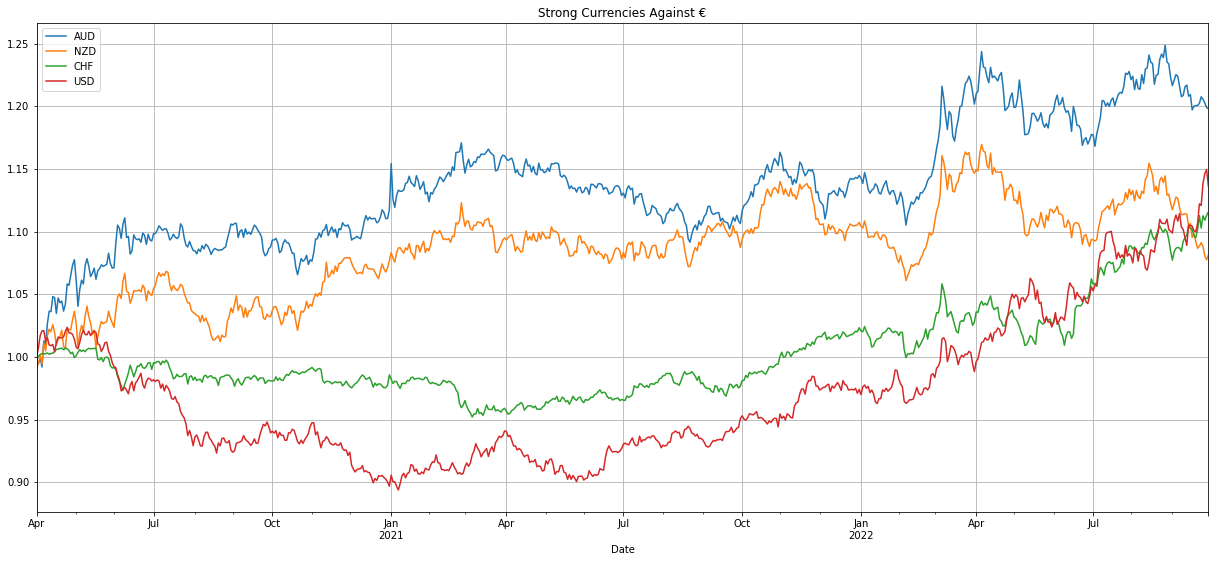

In [60]:
symbols = ["AUD","NZD","CHF","USD"]

plot_kwargs = {
    "figsize": (21,9),
    "legend": True
}

for fx in symbols:
    print(fx)
    (1+core_targets.query(f"symbols=='{fx}'").shift(1)["2020-4":]["t_RAWRET1D"]).cumprod().rename(fx).plot(        
        **plot_kwargs,
        title="Strong Currencies Against €"
    )

(1+core_targets.query(f"symbols=='{fx}'").shift(1)["2020-4":]["t_RAWRET1D"]).cumprod().rename(fx).plot(        
    **plot_kwargs,
    title="Strong Currencies Against €"
)
plt.grid();

In [62]:
#(Raw) Target Augmentation For MultiOutput Regression Trials
targets_merged_final = core_targets.merge(
    targets_merged,
    how="inner",
    on=["Date","symbols"]    
)


In [71]:
targets_merged_final.to_csv(
    PATH+"fx_data/20220929_FX_raw_targets.csv"
)

#### 8.1.2 Quantized

Repeat the Workflow for Shifted Features as Targets in Quantized Format $[1,~\dots,~10]$:

In [75]:
lst_qtargets = list()

# raw_targets melting and merging
for measures in features_dict:
    qtarget = pd.melt(
        features_dict[measures].rank(axis=1).shift(-1).dropna(),
        var_name=["symbols"],
        value_name="t_q"+measures,
        ignore_index=False
        ).sort_values(by=["Date","symbols"])
    
    lst_qtargets.append(qtarget)

In [77]:
qtargets_merged = reduce(
    lambda left, right: pd.merge(
        left, right,
        on=["Date","symbols"],
        how="inner"),
        lst_qtargets
  )

In [86]:
# Dropping ST Quantile Based PMs
bool_VARR1M = qtargets_merged.columns.str.startswith("t_qVARR1M")
bool_RACHEV1M = qtargets_merged.columns.str.startswith("t_qRACHEV1M")

In [ ]:
qtargets_merged = qtargets_merged.loc[:, ~bool_VARR1M & ~bool_RACHEV1M]

In [95]:
qtargets_merged.columns

Index(['symbols', 't_qMOM1W', 't_qMOM2W', 't_qMOM1M', 't_qMOM3M', 't_qEWVOL3M',
       't_qSRET1D', 't_qSRET3D', 't_qSRET1W', 't_qSRET2W', 't_qSRET1M',
       't_qISR1M', 't_qISR3M', 't_qISR6M', 't_qSKR1M', 't_qSKR3M', 't_qSKR6M',
       't_qVARR3M99', 't_qVARR3M95', 't_qVARR3M90', 't_qVARR3M80',
       't_qVARR6M99', 't_qVARR6M95', 't_qVARR6M90', 't_qVARR6M80',
       't_qRACHEV3M99', 't_qRACHEV3M95', 't_qRACHEV3M90', 't_qRACHEV3M80',
       't_qRACHEV6M99', 't_qRACHEV6M95', 't_qRACHEV6M90', 't_qRACHEV6M80',
       't_qSORTINO1M', 't_qSORTINO3M', 't_qSORTINO6M', 't_qOMEGA1M',
       't_qOMEGA3M', 't_qOMEGA6M'],
      dtype='object')

In [104]:
core_qtargets = pd.read_csv(
    PATH + "fx_data/20220929_FX_quantized_targets.csv",
    usecols=["Date","symbols","RET1DAH"],
    index_col="Date",
    parse_dates=["Date"]
).rename(columns={
    "RET1DAH": "t_qRAWRET1D"
})

In [105]:
core_qtargets

,symbols,t_qRAWRET1D
Date,,
2004-05-24,AUD,10
2004-05-24,CAD,1
2004-05-24,CHF,3
2004-05-24,DKK,5
2004-05-24,GBP,7
...,...,...
2022-09-29,JPY,2
2022-09-29,NOK,5
2022-09-29,NZD,7


In [107]:
core_qtargets.merge(
    qtargets_merged,
    on=["Date","symbols"]
).to_csv(
    PATH+"fx_data/20220929_FX_quantized_targets.csv"
)